# Lattice-Boltzmann in Python, C, and Verilog
### An example of hardware acceleration via FPGA
#### [V. Hunter Adams](https://vanhunteradams.com)

> - [Introduction](#Introduction)
> - [What is the Lattice Boltzmann Algorithm?](What-is-the-Lattice-Boltzmann-Algorithm?)
> - [Representation](#Representation)
> > - [Conceptual overview of representation](#Conceptual-overview-of-representation)
> > - [Python/C representation](#Python/C-representation)
> > - [Verilog representation](#Verilog-representation)
> - [Streaming](#Streaming)
> > - [Conceptual overview of streaming](#Conceptual-overview-of-streaming)
> > - [Python/C streaming](#Python/C-streaming)
> > - [Verilog streaming](#Verilog-streaming)
> - [Bouncing](#Bouncing)
> > - [Conceptual overview of bouncing](#Conceptual-overview-of-bouncing)
> > - [Python/C bouncing](#Python/C-bouncing)
> > - [Verilog bouncing](#Verilog-bouncing)
> - [Colliding](#Colliding)
> > - [Conceptual overview of colliding](#Conceptual-overview-of-colliding)
> > - [Python/C colliding](#Python/C-colliding)
> > - [Verilog colliding](#Verilog-colliding)
> - [Animation](#Animation)
> > - [Python animation](#Python-animation)
> > - [C animation](#C-animation)
> > - [Verilog animation](#Verilog-animation)

***

In [19]:
import numpy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
plt.rcParams["figure.figsize"] = (50,3)

***

## Introduction

This webpage introduces the Lattice-Boltmann algorithm and then demonstrates and compares implementations in Python, C, and Verilog. Please note that the Python implementation is not particularly "Pythonic." It was assembled in a way that maps more directly to C and Verilog. For its readability, Python is used for introducing the algorithm. At the relevant places, links are provided to the C and Verilog implementations.

The takeaway is that the Verilog implementation requires about 3.5x the number of lines of HDL as the C implementation requires lines of code, but rewards us with *way* faster execution. I put this together as a potential lab exercise for [ECE 5760](https://people.ece.cornell.edu/land/courses/ece5760/) at Cornell, but I think it's a bit too much to ask in the time dedicated to a single laboratory assignment. So, it'll become an in-class example of hardware acceleration via FPGA's.

The table below summarizes the performance for a variety of Lattice Boltzmann implementations. Note that the clock rates for Python and both C implementations are *faster* than that for the Verilog implementation (the PLL used by the Verilog is only 100MHz). The speedup associated with the Verilog implementation is due to the row-wise parallelism that it implements across the lattice. Note also that the rate of computation for the Verilog implementation is not affected by adding graphics because the FPGA makes use of [a custom VGA driver](https://vanhunteradams.com/DE1/VGA_Driver/Driver.html) which avoids VGA memory write bottlenecks.

**Looking for the code?** Please see the links in the top row of the table below.

$\hspace{1mm}$ | Python<br>(Mac M1) | C<br>(Arm A9 on DE1-SoC) | C<br>(Mac M1) | Verilog <br>(Cyclone V on DE1-SoC)
:- | :-: | :-: | :-: | :-:
Code | On this webpage | [Link](./lattice_boltzmann_de1.c.txt) | [Link](./lb.c.txt) | [Link](./lattice_boltzmann.v.txt)
Time for frame update<br>(no graphics)| 370ms | 14.5ms | 1.23ms | 0.087ms
Time for frame update<br>(+ graphics) | 452ms | 18.2ms |        | 0.087ms
Lines of code <br>(no graphics)       | ~165  | ~360   | ~360   | ~1230

<br><br><br>

<iframe width="560" height="315" src="https://www.youtube.com/embed/de33OTFvMXk" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

***

## What is the Lattice-Boltzmann Algorithm?

The Lattice-Boltzmann algorithm provides a method for doing computational fluid dynamics which does not require solving or discretizing the Navier-Stokes equations. Instead, we think about the fluid as a collection of molecules which exists on a grid (or "lattice"). For each generation of the simulation, we imagine that these particles move to adjacent cells on that lattice, and then they collide with other particles. The macroscopic properties of the fluid in each cell of the lattice (density, velocity, etc.) can then be computed from the particles that it contains. So, in short, the algorithm involves:

> 1. **Streaming**: All particle number densities move into adjacent/diagonal lattice cells.
> 2. **Bouncing**: Any particle number densities that have streamed into a cell containing a barrier are reflected back from whence they came.
> 3. **Collisions**: From the *new* set of number densities contained within each cell, we compute what the densities would be if the molecules in that cell were in thermal equilibrium. We then update all the densities in the cell toward this equilibrium state. The rate at which the cell moves toward its equilibrium state is related to the fluid's viscosity.

This method has some nice properties. It can accomodate for complex boundaries in a straightforward way and it parallelizes really nicely. This makes the algorithm very well suited for implementation on an FPGA. A limitation of this algorithm is that it cannot be used to simulate fluid flow at speeds comparable to, or larger than, the speed of sound.

***

## Representation

### Conceptual overview of representation

Lattice-Boltzmann simulations can be generated for a variety of different lattices (cubic, triangular, etc.). We classify the particular version of the Lattice-Boltmann algorithm using the "DnQm" naming convention, where "Dn" represents the number of dimensions and "Qm" represents the number of directions that particles can move. A common flavor of Lattice-Boltzmann (and the particular version which we'll treat in this project) is D2Q9. This is a simulation on a two-dimensional lattice, and particles on that lattice can move in nine different directions. A visual representation of that lattice is shown in Fig. 1.

<figure>
    <img align="center" width="300" height="300" src="lattice.png" alt='missing' />
    <center><figcaption>Fig. 1: Lattice for a D2Q9 Lattice-Boltmann simulation</figcaption></center>
</figure>

Each cell in this lattice contains ten states. Nine of those states represent the probability density for particles moving in the direction of each of the 8 adjacent cells (north, south, east, west, northeast, northwest, southeast, southwest) and of remaining on the current cell. These states are visually represented for the center cell in Fig. 2A, and labeled in Fig. 2B.

A | B 
- | - 
<img align="center" width="300" height="300" src="lattice_labeled.png" alt='missing' /><center><figcaption>Visual representation of states in each cell</figcaption></center> | <img align="center" width="340" height="340" src="states.png" alt='missing' /><center><figcaption>States in each cell with names</figcaption></center>
Fig. 2 | 

A particular cell of the lattice may also contain a barrier. These barrier-containing cells are represented by the gray boxes in Fig. 3. This is the (boolean) 10th state for each cell. If that boolean is true, then the cell contains a barrier. If not, then it does not contain a barrier.

<figure>
    <img align="center" width="300" height="300" src="barrier.png" alt='missing' />
    <center><figcaption>Fig. 3: Lattice with barrier</figcaption></center>
</figure>

### Python/C representation

In both Python and C, the instantaneous state of the lattice is contained in 10 arrays. Each of these arrays contains as many elements as there are cells in the lattice. A particular index of the array corresponds to a particular cell in the lattice, and each array holds one of the 10 states for the cell (north, south, east, west, northeast, northwest, southeast, southwest, null, barrier). In both Python and C, one could certainly use 2D arrays to organize this information. I chose to use 1D arrays so that I could work out some of the array manipulations that would be required in Verilog. The mapping from cell to index is `index = (cell row number) * (number of cells per row) + (cell column number)`. The mapping from array index to lattice cell is shown in Fig. 4. The Python code is provided below, and the corresponding C code can be found [at this link](./lb.c.txt).


<figure>
    <img align="center" width="300" height="300" src="index.png" alt='missing' />
    <center><figcaption>Fig. 4: Mapping from array index to cell</figcaption></center>
</figure>

In [29]:
# Parameters
height = 32                      # grid height
width = 512                      # grid width
viscosity = 0.002                # viscosity
omega = 1./(3*viscosity + 0.5)   # relaxation parameter (a function of viscosity)
u0 = 0.1                         # initial in-flow speed (eastward)
four9ths = 4./9.                 # a constant
one9th   = 1./9.                 # a constant
one36th  = 1./36.                # a constant

# Microscopic densities
n0  = numpy.zeros(height*width)  # Naught
nN  = numpy.zeros(height*width)  # North
nS  = numpy.zeros(height*width)  # South
nE  = numpy.zeros(height*width)  # East
nW  = numpy.zeros(height*width)  # West
nNW = numpy.zeros(height*width)  # Northwest
nNE = numpy.zeros(height*width)  # Northeast
nSE = numpy.zeros(height*width)  # Southeast
nSW = numpy.zeros(height*width)  # Southwest

# Barriers
bar = numpy.zeros(height*width)  # Barriers

# Macroscopic density and velocity
rho = numpy.zeros(height*width)    # Cell density
ux  = numpy.zeros(height*width)    # Cell x-velocity
uy  = numpy.zeros(height*width)    # Cell y-velocity
speed2 = numpy.zeros(height*width) # Cell squared velocity

### Verilog representation

In the Verilog implementation, there are 10 independent memory blocks associated with *each* row of the lattice. Each of these memory blocks can be read/written independently and in parallel, and all memory blocks in separate rows can be read/written in parallel. The first element in the memory block for each row corresponds to column 0, the second element corresponds to column 1, and so on. Please find the Verilog [at this link](lattice_boltzmann.v.txt).

<figure>
    <img align="center" width="800" height="300" src="vrep.png" alt='missing' />
    <center><figcaption>Fig. 5: Storing state information in Verilog</figcaption></center>
</figure>

***

## Streaming


### Conceptual overview of streaming

In the streaming step of the update, particle densities move to adjacent lattice cells. The "East" particle density of a particular cell becomes the "East" density of the cell to its east. Likewise for all other directions. The stationary (or "naught") densities for each cell remain in those cells. This is represented visually in Fig. 5. Note that, at this step, density may stream *into* barrier cells. The gray cells around the perimeter represent boundary conditions which never change.

A | B 
- | - 
<img align="center" width="340" height="340" src="stream1.png" alt='missing' /><center><figcaption>Before streaming</figcaption></center> | <img align="center" width="340" height="340" src="stream2.png" alt='missing' /><center><figcaption>After streaming</figcaption></center>
Fig. 5: Visualizing streaming| 

### Python/C streaming

In Python/C, streaming can be accomplished in one traversal of the lattice. Some pointer footwork is required to make certain that no cell is overwritten before its previous values have streamed. This means moving through the lattice from each of the four corners. The Python code which implements this is given below, and the corresponding C code can be viewed [here](./lb.c.txt).

In [13]:
def stream():
    
    # Stream all internal cells
    for x in range(0, width-1):
        for y in range(1, height-1):
            # Movement north (Northwest corner)
            nN[y*width + x] = nN[y*width + x + width]
            # Movement northwest (Northwest corner)
            nNW[y*width + x] = nNW[y*width + x + width + 1]
            # Movement west (Northwest corner)
            nW[y*width + x] = nW[y*width + x + 1]
            # Movement south (Southwest corner)
            nS[(height-y-1)*width + x] = nS[(height-y-1-1)*width + x]
            # Movement southwest (Southwest corner)
            nSW[(height-y-1)*width + x] = nSW[(height-y-1-1)*width + x + 1]
            # Movement east (Northeast corner)
            nE[y*width + (width-x-1)] = nE[y*width + (width-(x+1)-1)]
            # Movement northeast (Northeast corner)
            nNE[y*width + (width-x-1)] = nNE[y*width + width + (width-(x+1)-1)]
            # Movement southeast (Southeast corner)
            nSE[(height-y-1)*width + (width-x-1)] = nSE[(height-y-1-1)*width +
                                                        (width-(x+1)-1)]  
            
    # Tidy up the edges
    x += 1
    for y in range(1, height-1):
        # Movement north on right boundary (Northwest corner)
        nN[y*width + x] = nN[y*width + x + width]
        # Movement south on right boundary (Southwest corner)
        nS[(height-y-1)*width + x] = nS[(height-y-1-1)*width + x]

### Verilog streaming

All *rows* of the lattice are streamed in *parallel* on the FPGA. We do this by introducing a two-column pipeline to the memory block reads. We then scan from column 0 to the final column, and we rewrite the data in each memory block as we move. This is the first example of acceleration via parallelization on the FPGA. We needn't loop through every cell in the lattice, we need only loop through every column.

The full state machine is linked [here](./lattice_boltzmann.v.txt). Streaming occurs in states 20-23.

***

## Bouncing

### Conceptual overview of bouncing

After all particle densities have moved to adjacent lattice cells, we do a subsequent pass through the lattice to bounce densities off of barriers. Any cell which contains a barrier reflects any densities that it contains after streaming *back* into the cell from which it streamed. When those densities are bounced back, they also reverse direction. So, if a cell streamed density eastward into a barrier, that density would bounce back and point westward after bouncing. This is illustrated in Fig. 6.

A | B | C 
- | - | - 
<img align="center" width="340" height="340" src="stream1.png" alt='missing' /><center><figcaption>Before streaming</figcaption></center> | <img align="center" width="340" height="340" src="stream2.png" alt='missing' /><center><figcaption>After streaming, before bouncing</figcaption></center> | <img align="center" width="340" height="340" src="stream3.png" alt='missing' /><center><figcaption>After bouncing</figcaption></center>
 |Fig. 6: Streaming and bouncing | 

### Python/C bouncing

As with streaming, we loop through all cells in the lattice (omitting those at the boundaries, where boundary conditions are enforced). If a particular cell contains a barrier, then any densities contained in that cell get pushed back from whence they came, reversing direction in the process. The Python code which implements this is given below, and the corresponding C code can be viewed [here](./lb.c.txt).

In [14]:
def bounce():
    
    # Loop through all interior cells
    for x in range(2, width-2):
        for y in range(2, height-2):
            
            # If the cell contains a boundary . . .
            if (bar[y*width + x]):
                
                # Push densities back from whence they came
                nN[(y-1)*width + x] = nS[y*width + x]
                nS[(y+1)*width + x] = nN[y*width + x]
                nE[y*width + x + 1] = nW[y*width + x]
                nW[y*width + (x-1)] = nE[y*width + x]    
                nNE[(y-1)*width + (x+1)] = nSW[y*width + x]
                nNW[(y-1)*width + (x-1)] = nSE[y*width + x]
                nSE[(y+1)*width + (x+1)] = nNW[y*width + x]
                nSW[(y+1)*width + (x-1)] = nNE[y*width + x]
                
                # Clear the densities in the barrier cells
                n0[y*width + x] = 0
                nN[y*width + x] = 0
                nS[y*width + x] = 0
                nE[y*width + x] = 0
                nW[y*width + x] = 0
                nNE[y*width + x] = 0
                nNW[y*width + x] = 0
                nSE[y*width + x] = 0
                nSW[y*width + x] = 0
                

### Verilog bouncing

As with streaming, the Verilog implements bouncing in parallel across all rows. Rather than moving through every cell in the lattice, we instead move through every column. [See states 0-4](./lattice_boltzmann.v.txt).

***

## Colliding

### Conceptual overview of colliding

**Note**: For an approachable derivation of the equations presented in this section, please see [Daniel Schroeder's writeup on the topic](https://physics.weber.edu/schroeder/javacourse/LatticeBoltzmann.pdf).

After streaming, each cell in the lattice has a new set of values for its nine densities. From those densities, we can compute the macroscopic density for that cell, and the average (macroscopic) cell velocities.

\begin{align}
\rho &= n_0 + n_N + n_E + n_S + n_W + n_{NE} + n_{SE} + n_{SW} + n_{NW} = \text{total density}\\
u_x &= \frac{n_E + n_{NE} + n_{SE} - n_W - n_{NW} - n_{SW}}{\rho} = \text{average cell x velocity}\\
u_y &= \frac{n_N + n_{NE} + n_{NW} - n_S - n_{SE} - n_{SW}}{\rho} = \text{average cell y velocity}
\end{align}

From the macroscopic density $\rho$ and velocity $\overline{u} = [u_x, u_y]$, we can compute what the nine densities *would be* if the system were in equilibrium.

\begin{align}
n_i^{eq} &= \rho w_i \left[ 1 + 3\overline{e}_i \cdot \overline{u} + \frac{9}{2} \left(\overline{e}_i \cdot \overline{u}\right)^2 - \frac{3}{2} |\overline{u}|^2\right]
\end{align}

Each of those $w_i$'s is a weight.

\begin{align}
\omega_0 = \frac{4}{9} && \omega_N = \omega_E = \omega_S = \omega_W = \frac{1}{9} && \omega_{NE} = \omega_{NW} = \omega_{SW} = \omega_{SE} = \frac{1}{36}
\end{align}

From the general expression above, we can write down the specific expressions for each of the nine densitites.

\begin{align}
n_0^{eq} &= \rho \cdot \frac{4}{9} \left[1 - \frac{3}{2}\left(u_x^2 + u_y^2\right)\right]\\
n_N^{eq} &= \rho \cdot \frac{1}{9} \left[1 + 3u_y + \frac{9}{2}u_y^2- \frac{3}{2}\left(u_x^2 + u_y^2\right)\right]\\
n_S^{eq} &= \rho \cdot \frac{1}{9} \left[1 - 3u_y + \frac{9}{2}u_y^2- \frac{3}{2}\left(u_x^2 + u_y^2\right)\right]\\
n_E^{eq} &= \rho \cdot \frac{1}{9} \left[1 + 3u_x + \frac{9}{2}u_x^2- \frac{3}{2}\left(u_x^2 + u_y^2\right)\right]\\
n_W^{eq} &= \rho \cdot \frac{1}{9} \left[1 - 3u_x + \frac{9}{2}u_x^2- \frac{3}{2}\left(u_x^2 + u_y^2\right)\right]\\
n_{NE}^{eq} &= \rho \cdot \frac{1}{36} \left[1 + 3(u_x+u_y) + \frac{9}{2}(u_x+u_y)^2- \frac{3}{2}\left(u_x^2 + u_y^2\right)\right]\\
n_{SE}^{eq} &= \rho \cdot \frac{1}{36} \left[1 + 3(u_x-u_y) + \frac{9}{2}(u_x-u_y)^2- \frac{3}{2}\left(u_x^2 + u_y^2\right)\right]\\
n_{NW}^{eq} &= \rho \cdot \frac{1}{36} \left[1 + 3(-u_x+u_y) + \frac{9}{2}(-u_x+u_y)^2- \frac{3}{2}\left(u_x^2 + u_y^2\right)\right]\\
n_{SW}^{eq} &= \rho \cdot \frac{1}{36} \left[1 + 3(-u_x-u_y) + \frac{9}{2}(-u_x-u_y)^2- \frac{3}{2}\left(u_x^2 + u_y^2\right)\right]\\
\end{align}

In practice, we'll compute the total density, compute all eight nonzero densities, and then determine the zero vector density such that it conserves mass. If we wanted for the time scale for reaching equilibrium to match the timestep of the simulation, then we would simply set all the cell densities to these equilibrium values. But these two timescales needn't be identical, so we will instead relax the system toward equilibrium with the parameter $\omega$. This parameter is related to the viscosity of the fluid. A larger $\omega$ means that the collisions happen more quickly.

\begin{align}
n_i^{new} &= n_{i}^{old} + \omega\left(n_i^{eq} - n_i^{old}\right)
\end{align}

Once all the new densities have been computed for each cell, we might draw an updated picture (of speed, or density, or curl), and then stream all particles and go through the process again.

### Python/C colliding

The Python code which implements collisions is shown below, and the corresponding C code can be viewed [here](./lb.c.txt).

In [15]:
def collide():
    
    # Do not touch cells on top, bottom, or left
    for x in range(1, width-1):
        for y in range(1, height-1):
            
            # What's our current index?
            i = y*width + x
            
            # Skip over cells containing barriers
            if (bar[i]):
                continue
                
            else:
                # Compute the macroscopic density
                rho[i] = n0[i] + nN[i] + nE[i] + nS[i] + nW[i] + nNE[i] + nSE[i] + nSW[i] + nNW[i]
                # Compute the macroscopic velocities
                if (rho[i] > 0):
                    ux[i]  = (nE[i] + nNE[i] + nSE[i] - nW[i] - nNW[i] - nSW[i]) * (1-(rho[i]-1)+((rho[i]-1)**2.))
                    uy[i]  = (nN[i] + nNE[i] + nNW[i] - nS[i] - nSE[i] - nSW[i]) * (1-(rho[i]-1)+((rho[i]-1)**2.))
                    
                # Pre-compute some convenient constants
                one9th_rho = one9th * rho[i]
                one36th_rho = one36th * rho[i]
                vx3 = 3 * ux[i]
                vy3 = 3 * uy[i]
                vx2 = ux[i] * ux[i]
                vy2 = uy[i] * uy[i]
                vxvy2 = 2 * ux[i] * uy[i]
                v2 = vx2 + vy2
                speed2[i] = v2
                v215 = 1.5 * v2
                
                # Update densities
                nE[i]  += omega * (   one9th_rho * (1 + vx3       + 4.5*vx2        - v215) - nE[i])
                nW[i]  += omega * (   one9th_rho * (1 - vx3       + 4.5*vx2        - v215) - nW[i])
                nN[i]  += omega * (   one9th_rho * (1 + vy3       + 4.5*vy2        - v215) - nN[i])
                nS[i]  += omega * (   one9th_rho * (1 - vy3       + 4.5*vy2        - v215) - nS[i])
                nNE[i] += omega * (  one36th_rho * (1 + vx3 + vy3 + 4.5*(v2+vxvy2) - v215) - nNE[i])
                nNW[i] += omega * (  one36th_rho * (1 - vx3 + vy3 + 4.5*(v2-vxvy2) - v215) - nNW[i])
                nSE[i] += omega * (  one36th_rho * (1 + vx3 - vy3 + 4.5*(v2-vxvy2) - v215) - nSE[i])
                nSW[i] += omega * (  one36th_rho * (1 - vx3 - vy3 + 4.5*(v2+vxvy2) - v215) - nSW[i])
                
                # Conserve mass
                n0[i]   = rho[i] - (nE[i]+nW[i]+nN[i]+nS[i]+nNE[i]+nSE[i]+nNW[i]+nSW[i]);

### Verilog colliding

The particular FPGA that I'm using (a Cyclone V on a DE1-SoC) contains 74 DSP blocks. I'm using fixed-point, 3.17 arithmetic, which means that each row can use two multipliers in parallel. The arithmetic described above is implemented in a 13-stage state machine, which uses (at maximum) two multipliers per state. As with bouncing and streaming, collisions are row-wise parallel. [See states 5-18 in the Verilog](./lattice_boltzmann.v.txt).

## Initial conditions

For this particular simulation, all cells get initialized with a density of 1, and with an eastward macroscopic velocity $u_x$ of 0.1. From this macroscopic velocity, we compute all the equilibrium number densities. The initialization function also builds a linear boundary of user-specified height and location on the lattice.

### Python initializations

The Python code which initializes the lattice is given below. The corresponding C code can be viewed [here](./lb.c.txt).

In [11]:
def initialize(xtop, ytop, yheight, u0=u0):
    xcoord = 0
    ycoord = 0
    
    count = 0
    for i in range(height*width):
        n0[i] = four9ths* (1 - 1.5*(u0**2.))
        nN[i] = one9th  * (1 - 1.5*(u0**2.))
        nS[i] = one9th  * (1 - 1.5*(u0**2.))
        nE[i] = one9th  * (1 + 3*u0 + 4.5*(u0**2.) - 1.5*(u0**2.))
        nW[i] = one9th  * (1 - 3*u0 + 4.5*(u0**2.) - 1.5*(u0**2.))
        nNE[i]= one36th * (1 + 3*u0 + 4.5*(u0**2.) - 1.5*(u0**2.))
        nSE[i]= one36th * (1 + 3*u0 + 4.5*(u0**2.) - 1.5*(u0**2.))
        nNW[i]= one36th * (1 - 3*u0 + 4.5*(u0**2.) - 1.5*(u0**2.))
        nSW[i]= one36th * (1 - 3*u0 + 4.5*(u0**2.) - 1.5*(u0**2.))
        
        rho[i] =  n0[i] + nN[i] + nS[i] + nE[i] + nW[i] + nNE[i] + nSE[i] + nNW[i] + nSW[i]
        
        ux[i]  = (nE[i] + nNE[i] + nSE[i] - nW[i] - nNW[i] - nSW[i]) * (1-(rho[i]-1)+((rho[i]-1)**2.))
        uy[i]  = (nN[i] + nNE[i] + nNW[i] - nS[i] - nSE[i] - nSW[i]) * (1-(rho[i]-1)+((rho[i]-1)**2.))
        
        if (xcoord==xtop):
            if (ycoord >= ytop):
                if (ycoord < (ytop+yheight)):
                    count += 1
                    bar[ycoord*width + xcoord] = 1
        
        xcoord = (xcoord+1) if xcoord<(width-1) else 0
        ycoord = ycoord if (xcoord != 0) else (ycoord + 1)

### Verilog initializations

Initialization occurs in [state 19](./lattice_boltzmann.v.txt).

***

## Animation

We animate the fluid motion over the barriers by repeatedly streaming, bouncing, and colliding the densities. One might choose to visualize any one of a number of macroscopic cell properties (x velocity, y velocity, density, curl, etc.). In these animations, we visualize the squared velocity of the fluid in each cell.

### Python animation

The code for generating an animation in Python is provided below. To generate each of the two animations shown in the embedded video took a few hours.

<iframe width="560" height="315" src="https://www.youtube.com/embed/FB2ykB5bLnM" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

Done!


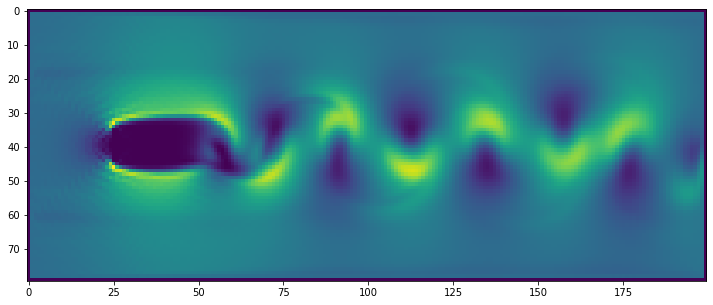

In [70]:
# Frames per second, and number of seconds
fps = 600
nSeconds = 15

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(20,5) )

# Initialize the barriers (occurs in previous section)
initialize(25, 11, 10)

# Don't animate first few frames
for i in range(10):
    stream()
    bounce()
    collide()

# Plot which we'll be animating
a = speed2
im = plt.imshow(a.reshape(height,width))

# Animation function (stream, bounce, collide, and update heatmap)
def animate_func(i):
    stream()
    bounce()
    collide()
    im.set_array(speed2.reshape(height, width))
    return [im]

# Animation object
anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )

print('Done!')

# Generate an mp4 video of the animation
f = r"./animation4.mp4" 
writervideo = animation.FFMpegWriter(fps=600) 
anim.save(f, writer=writervideo)

### C animation

The C code animates to the VGA display by means of the [Altera video core](./Video_core.pdf). The Arm A9 communicates pixel data from L3 cache --> Axi bus --> Avalon bus --> SDRAM. Then, the Altera video core scans through that SDRAM to gather pixel data for display. The associated C code is available [here](./lattice_boltzmann_de1.c.txt).


### Verilog animation

The Verilog uses a [custom VGA driver](https://vanhunteradams.com/DE1/VGA_Driver/Driver.html) to avoid bottlenecks when writing to VGA memory. Each parallel solver writes to its own memory block (in parallel), and the custom VGA driver then multiplexes into those memory blocks to access pixel information. The memory blocks support read during write, so this eliminates all bottlenecks and avoids transactions over the Avalon bus.

***